# Imports

In [1]:
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras

from keras.utils import pad_sequences
from keras.layers import Dense, Embedding, GRU

from keras.preprocessing.text import Tokenizer

from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

# Check if GPU is being used or not
print(tf.config.list_physical_devices("GPU"))

2023-01-08 23:22:30.208186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 23:22:30.750010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jj/miniconda3/envs/tf/lib/
2023-01-08 23:22:30.750084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jj/miniconda3/envs/tf/lib/
2023-01-08 23:22:30.750091: W tensorflow/compiler/tf2tensorrt/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-08 23:22:31.802871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-08 23:22:31.807310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-08 23:22:31.807530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.


## Handle Captions

### Load Captions

In [2]:
caption_file = "dataset/Flicker8k_text/Flickr8k.token.indo.txt"


def load_captions(filename):
    with open(filename, "r") as file:
        # Read all text
        text = file.read()
        return text


# Create dictionary of photo to their respective captions. Each photo maps to a list of one or more captions
def captions_dict(text):
    dict = {}

    # Make a List of each line in the file
    lines = text.split("\n")
    for line in lines:
        # Split line to <image> and <caption>
        line_split = line.split("\t")
        if len(line_split) != 2:
            continue  # Ignore blank lines
        else:
            image, caption = line_split

        # Split image to <image_file> and <caption_idx>
        image_file, caption_idx = image.split("#")
        # Split .jpg
        image_name = image_file.split(".")[0]

        # Check if this is the first caption for the image
        # Create new list for the image and add captions to it, otherwise append to list
        if int(caption_idx) == 0:
            dict[image_name] = [caption]
        else:
            dict[image_name].append(caption)

    return dict


document = load_captions(caption_file)
image_dict = captions_dict(document)

### Split Captions for Training

In [3]:
# Given a file, return a set of image names without .jpg from that file
# In this case, we take the .train.Images.txt file to get the images for training
def subset_image(filename):
    data = []
    with open(filename, "r") as file:
        # Read all text in the file
        text = file.read()

        # Make a List of each line in the file
        lines = text.split("\n")
        for line in lines:
            if len(line) < 1:
                continue # Ignore blank lines
            # Split .jpg
            image_name = line.split(".")[0]

            # Add the <image_name>to the List
            data.append(image_name)

        return set(data)

training_image_file = "dataset/Flicker8k_text/Flickr_8k.trainImages.txt"
training_image_names = subset_image(training_image_file)

## Preprocess Images

In [4]:
# Use the InceptionV3 model without the Classifier part
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Define img as a jpg with 3 colour channels
    img = tf.image.resize(img, (299, 299))  # Resize all images to 299x299
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


image_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")
new_input = image_model.input
hidden_layer = image_model.layers[-1].output  # Removing Classifier
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_dir = "dataset/Flicker8k_Dataset/"
# Get all image names for training
training_image_paths = [image_dir + name + ".jpg" for name in training_image_names]

# Get unique images
encode_train = sorted(set(training_image_paths))

BATCH_SIZE = 64

# * -- Uncomment below to Re-encode Images -- * #
# # Encode images
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#     load_image, num_parallel_calls=tf.data.AUTOTUNE
# ).batch(BATCH_SIZE)

# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(
#         batch_features, (batch_features.shape[0], -1, batch_features.shape[3])
#     )

#     # Save encoded image features to .npy file
#     for (feature,path,) in zip(batch_features, path):
#         path_of_feature = path.numpy().decode("utf-8")
#         np.save(path_of_feature, feature.numpy())

2023-01-08 23:22:31.875623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 23:22:31.876701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-08 23:22:31.877008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-08 23:22:31.877238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_nod

## Prepare Captions - Tokenizer

In [5]:
# Clean the captions data by:
#   Converting all words to lowercase
#   Removing all punctuations
#   Removing all words that are one character or less
#   Removing all words with numbers

def clean_captions(image_dict):
    # ignore image_name by dividing image_dict to name and captions
    for name, captions in image_dict.items():
        # Loop through each caption for an image
        for i, caption in enumerate(captions):
            # Convert captions to lowercase and remove special characters
            caption_nopunctuation = re.sub(r"[^a-zA-Z0-9]+", " ", caption.lower())

            # Split caption into separate words
            # Collect all words that contains only alphabets and are more than one character
            clean_words = [
                word
                for word in caption_nopunctuation.split()
                if ((len(word) > 1) and (word.isalpha()))
            ]

            # Join words into a string
            caption_new = " ".join(clean_words)

            # Replace old caption with new cleaned caption
            captions[i] = caption_new


# Add tokens 'startseq' and 'endseq' at beginning and end of every caption
def add_tokens(captions):
    for i, caption in enumerate(captions):
        captions[i] = "startseq " + caption + " endseq"
    return captions


# Given a set of images, return dict containing corresponding subset from full dict of images with captions
def subset_dict(image_dict, image_names):
    dict = {
        image_name: add_tokens(captions)
        for image_name, captions in image_dict.items()
        if image_name in image_names
    }
    return dict

# List of all captions
def all_captions(data_dict):
    return [caption for name, captions, in data_dict.items() for caption in captions]

# Calculate the max word-length from all captions
def max_caption_length(captions):
    return max(len(caption.split()) for caption in captions)

# Fit Tokenizer given caption descriptions
# The tokenizer will then be used to encode captions as numbers
def create_tokenizer(data_dict):
    captions = all_captions(data_dict)
    max_caption_words = max_caption_length(captions)
    tokenizer = Tokenizer() # Keras Tokenizer

    # Fit captions to Tokenizer
    tokenizer.fit_on_texts(captions)
    # Get size of vocab
    vocab_size = len(tokenizer.word_index) + 1

    return (tokenizer, vocab_size, max_caption_words)

# Extend list of text to a given fixed length
def pad_text(text, max_length):
    text = pad_sequences([text], maxlen=max_length, padding="post")[0]
    return text

clean_captions(image_dict)
training_dict = subset_dict(image_dict, training_image_names)

# Prep Tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)

## Prepare Training Data

In [6]:
# Go through every training image and caption to prepare training data
# X = Features (image paths)
# y = Targets (cleaned and tokenized captions)


def data_prep(data_dict, tokenizer, max_length, vocab_size):
    X, y = list(), list()

    # For each image and list of captions
    for image_name, captions in data_dict.items():
        image_name = image_dir + image_name + ".jpg"

        # For each caption in list of captions
        for caption in captions:
            # Convert captions into a list of word indices
            word_idxs = tokenizer.texts_to_sequences([caption])[0]

            # Pad inputted text to the same fixed length
            pad_idxs = pad_text(word_idxs, max_length)

            X.append(image_name)
            y.append(pad_idxs)

    return X, y


train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, vocab_size)

# Wrap the training data into a tf Dataset object to be fetched one batch at a time efficiently

BUFFER_SIZE = 1000

# Load .npy files
def map_func(image_name, caption):
    image_tensor = np.load(image_name.decode("utf-8") + ".npy")
    return image_tensor, caption


dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load .npy files in parallel
dataset = dataset.map(
    lambda first, second: tf.numpy_function(
        map_func, [first, second], [tf.float32, tf.int32]
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Shuffle and batch data
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Prepare Image Caption Model with Attention

In [7]:
# The model consists of:
# 1. Encoder -> Takes pre-encoded image features to pass onto Decoder
# 2. Decoder -> RNN with GRU
# 3. Attention -> Focus on the most relevant part of the image to generate word
# 4. Sentence Generator -> Takes output from Decoder and produces prob. for each word form the vocab

# Encoder
class CNN_Encoder(tf.keras.Model):
    # Encoder only passes through previously encoded features through a Fully Connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = Dense(embedding_dim)  # Fully Connected layer
        self.__name = "CNN_Encoder"

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

    def savemodel(self):
        self.save_weights(f"models/{self.__name}")
        print(f"Model {self.__name} saved!")

    def loadmodel(self):
        self.load_weights(f"models/{self.__name}")
        return self


# Decoder
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.model = tf.keras.Model
        self.units = units

        # Embedding Layer
        self.embedding = Embedding(vocab_size, embedding_dim)
        # Gru Layer
        self.gru = GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        # 2 Dense Fully Connected Layers
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

        self.__name = "RNN_Decoder"

    def call(self, x, features, hidden):
        # Defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after embedding -> (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # After concat -> (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Pass concat vector to GRU
        output, state = self.gru(x)

        # x shape -> (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape -> (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # Final shape -> (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

    def savemodel(self):
        self.save_weights(f"models/{self.__name}")
        print(f"Model {self.__name} saved!")

    def loadmodel(self):
        self.load_weights(f"models/{self.__name}")
        return self


# Attention
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features shape -> (batch_size, 64, embedding_dim)
        # hidden shape -> (batch_size, hidden_size)
        # hidden_with_time shape -> (batch_size, 1, hidden_size)
        hidden_with_time = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape -> (batch_size, 64, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time)
        )

        # score shape -> (batch_size, 64, 1). Gives unnormalized score for each image feature
        score = self.V(attention_hidden_layer)

        # attention_weights shape -> (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum -> (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


## Model Training

In [8]:
EMBEDDING_DIM = 256
UNITS = 512
VOCAB_SIZE = vocab_size
NUM_STEPS = len(train_X) // BATCH_SIZE
# Shape of vector from InceptionV3 -> (64, 2048)
FEATURES_SHAPE = 2048
ATTENTION_FEATURES_SHAPE = 64

encoder = CNN_Encoder(EMBEDDING_DIM)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")


def loss_func(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


loss_plot = []


@tf.function
def train_step(image_tensor, target):
    loss_ = 0

    # Initialize hidden state for each batch as each image captions are not related to each other
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["startseq"]] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(image_tensor)

        for i in range(1, target.shape[1]):
            # Passing features through Decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss_ += loss_func(target[:, i], predictions)

            # Use Teacher Forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss_ / int(target.shape[1])
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss_, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss_, total_loss

# * -- Uncomment below to Train Model -- * #
# # Use 20 epochs for training
# EPOCHS = 20

# for epoch in range(0, EPOCHS):
#     start = time.time()
#     total_loss = 0

#     for (batch, (image_tensor, target)) in enumerate(dataset):
#         batch_loss, t_loss = train_step(image_tensor, target)
#         total_loss += t_loss

#         if batch % 100 == 0:
#             average_batch_loss = batch_loss.numpy() / int(target.shape[1])
#             print(f"Epoch {epoch + 1} Batch {batch} Loss {average_batch_loss:.4f}")

#     # Store epoch and loss value for plotting
#     loss_plot.append(total_loss / NUM_STEPS)

#     print(f"Epoch {epoch + 1} Loss {total_loss / NUM_STEPS:.6f}")
#     print(f"Time taken for this epoch: {time.time() - start:.2f} seconds\n")

# # Save models for future use
# encoder.savemodel()
# decoder.savemodel()

## Model Evaluation

In [9]:
# If model save exists
encoder = CNN_Encoder(EMBEDDING_DIM)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

encoder.loadmodel()
decoder.loadmodel()

def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, ATTENTION_FEATURES_SHAPE))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    image_tensor_val = image_features_extract_model(temp_input)
    image_tensor_val = tf.reshape(
        image_tensor_val, (image_tensor_val.shape[0], -1, image_tensor_val.shape[3])
    )

    features = encoder(image_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index["startseq"]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == "endseq":
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[: len(result), :]
    return result, attention_plot


def check_test(test_image_names, image_dict, image_dir, max_caption_words):
    # Captions on validation set
    rid = np.random.randint(0, len(test_image_names))
    image_name = test_image_names[rid]
    real_caption = image_dict[image_name]

    image_path = image_dir + image_name + ".jpg"
    result, attention_plot = evaluate(image_path, max_caption_words)
    result.pop() # Remove 'endseq' from result

    count = 0
    real_caption_split = real_caption.copy()
    for caption in real_caption_split:
        caption = caption.split()
        real_caption_split[count] = caption
        count += 1
    score = sentence_bleu(real_caption_split, result, weights=(1, 0, 0, 0))

    from IPython.display import Image, display

    display(Image(image_path))
    print("Real Caption:", real_caption)
    print("Prediction Caption:", " ".join(result))
    print(f"BLEU-1 score: {score * 100}")


test_image_file = "dataset/Flicker8k_text/Flickr_8k.testImages.txt"
test_image_names = subset_image(test_image_file)
image_dir = "dataset/Flicker8k_Dataset/"

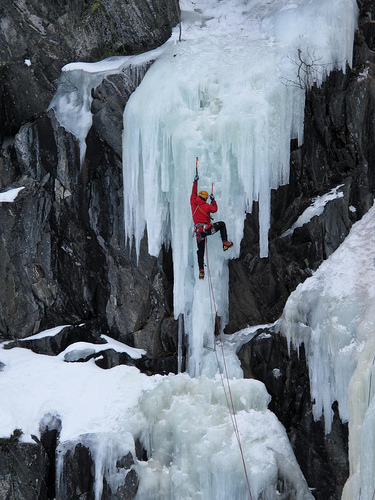

Real Caption: ['seorang pria memanjat es di permukaan batu', 'seorang pria memanjat batu es', 'seorang pria memanjat dinding es tipis', 'seorang pria berjaket merah mendaki gunung batu es', 'seseorang dengan pakaian merah dan hitam mendaki sisi gunung es']
Prediction Caption: seorang pria memanjat batu batu yang jatuh
BLEU-1 score: 57.14285714285714


In [14]:
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

## Final Evaluation

In [11]:
def bleu_test(test_image_names, image_dict, image_dir, max_caption_words):
    # Captions on validation set
    # Set up for Bleu score results
    scores1 = []
    scores2 = []
    scores3 = []
    scores4 = []

    # Go through the whole validation set
    for rid in tqdm(range(len(test_image_names))):
        image_name = test_image_names[rid]
        real_caption = image_dict[image_name]

        image_path = image_dir + image_name + ".jpg"
        result, attention_plot = evaluate(image_path, max_caption_words)
        result.pop()  # Remove 'endseq' from result

        count = 0
        real_caption_split = real_caption.copy()
        for caption in real_caption_split:
            if type(caption) == str:
                caption = caption.split()
                real_caption_split[count] = caption
                count += 1
        score1 = sentence_bleu(real_caption_split, result, weights=(1, 0, 0, 0))
        score2 = sentence_bleu(real_caption_split, result, weights=(0.5, 0.5, 0, 0))
        score3 = sentence_bleu(
            real_caption_split, result, weights=(0.33, 0.33, 0.33, 0)
        )
        score4 = sentence_bleu(
            real_caption_split, result, weights=(0.25, 0.25, 0.25, 0.25)
        )

        scores1.append(score1 * 100)
        scores2.append(score2 * 100)
        scores3.append(score3 * 100)
        scores4.append(score4 * 100)

    average_score1 = sum(scores1) / len(test_image_names)
    average_score2 = sum(scores2) / len(test_image_names)
    average_score3 = sum(scores3) / len(test_image_names)
    average_score4 = sum(scores4) / len(test_image_names)

    print(f"Average BLEU-1 Score: {average_score1:.3f}")
    print(f"Average BLEU-2 Score: {average_score2:.3f}")
    print(f"Average BLEU-3 Score: {average_score3:.3f}")
    print(f"Average BLEU-4 Score: {average_score4:.3f}")


test_image_file = "dataset/Flicker8k_text/Flickr_8k.testImages.txt"
test_image_names = subset_image(test_image_file)
image_dir = "dataset/Flicker8k_Dataset/"

bleu_test(list(test_image_names), image_dict, image_dir, max_caption_words)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:15<00:00,  5.10it/s]

Average BLEU-1 Score: 39.037
Average BLEU-2 Score: 21.205
Average BLEU-3 Score: 8.012
Average BLEU-4 Score: 2.777
